## Prerequisite Packages

In [2]:
# Based on https://www.tensorflow.org/datasets/keras_example
# use pip install <package> to find any packages that are missing
import keras         # for fitting DNNs
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.patheffects as PathEffects

## We split the data into training and testing

In [3]:
(ds_train,ds_val, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train[:80%]','train[80%:]','test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


## Functions: normalizing images, and returning labels/images

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label
def get_label(image,label):
    return label
def get_image(image,label):
    return image


## We apply these functions to extract model-ready data

In [5]:
# this just normalizes the image
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# cache and prefetch save memory 
ds_train = ds_train.cache()
# we shuffle data (reduces effects of order when training model)
ds_train = ds_train.shuffle(ds_info.splits['train[:80%]'].num_examples)
# batch size tells us how many samples are needed for stochastic gradient descent 
# (a small number like 32 is empirically found to be better)
ds_train = ds_train.batch(32)# batch of 32
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)


ds_val = ds_val.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.cache()
ds_val = ds_val.shuffle(ds_info.splits['train[80%:]'].num_examples)
ds_val = ds_val.batch(32)# batch of 32
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)


ds_test_label=ds_test.map(
    get_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test_images=ds_test.map(
    get_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)



## Model training

In [6]:

# this example model 
#    - first flattens data into a vector (image is 28 x 28)
#    - then creates a dense 128-node layer
#    - then creates a dropout "layer" (it says how many nodes are dropped out in previous layer)
#    - then another 128-node layer
#    - and finally 10-node layer as the head. 
# The max value of the head = the predicted image
#
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128,activation='relu'),
tf.keras.layers.Dropout(.2, input_shape=(128,)), #drop previous dense, allow regularization, improve the model.
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10)
])

# this specifies how we find the best NN
# - Optimizer like Adam is found to work well
# - Loss is "sparse categorical cross entropy" (you can choose whatever loss function on keras improves your model)
# - We also record accuracy ("metric"), this does not affect training
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),    #loss: categorical 不需要 mean-square
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],    #Reference: https://blog.csdn.net/A_a_ron/article/details/79050204

)
# this is stuff we record
# "early stopping" tells us when we found the optimum without training more epochs
#EarlyStopping则是用于提前停止训练的callbacks。具体地，可以达到当训练集上的loss不在减小（即减小的程度小于某个阈值）的时候停止继续训练。 
#Reference: https://blog.csdn.net/zwqjoy/article/details/86677030#:~:text=EarlyStopping%E6%98%AFCallbacks%E7%9A%84%E4%B8%80,%E8%BF%9B%E8%A1%8C%E5%93%AA%E7%A7%8D%E7%89%B9%E5%AE%9A%E6%93%8D%E4%BD%9C%E3%80%82&text=EarlyStopping%E5%88%99%E6%98%AF%E7%94%A8%E4%BA%8E,%E7%9A%84%E6%97%B6%E5%80%99%E5%81%9C%E6%AD%A2%E7%BB%A7%E7%BB%AD%E8%AE%AD%E7%BB%83%E3%80%82
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=8),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

# the training of the model
# we use ds_train data, and up to 30 epochs (less when Early Stopping is used)
# we also record callbacks, and we determine the optimal model by where validation is smallest
history=model.fit(
    ds_train,
    epochs=30,
    callbacks=my_callbacks,
    validation_data=ds_val
)


#model.predict_classes(ds_test, verbose=1)

Epoch 1/30
1500/1500 [==============================] - 8s 3ms/step - loss: 0.5191 - sparse_categorical_accuracy: 0.8454 - val_loss: 0.1515 - val_sparse_categorical_accuracy: 0.9519
Epoch 2/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.9540 - val_loss: 0.1065 - val_sparse_categorical_accuracy: 0.9682
Epoch 3/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1086 - sparse_categorical_accuracy: 0.9647 - val_loss: 0.1011 - val_sparse_categorical_accuracy: 0.9695
Epoch 4/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0835 - sparse_categorical_accuracy: 0.9742 - val_loss: 0.0905 - val_sparse_categorical_accuracy: 0.9742
Epoch 5/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0794 - sparse_categorical_accuracy: 0.9744 - val_loss: 0.0900 - val_sparse_categorical_accuracy: 0.9759
Epoch 6/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0670 - spars

In [7]:
history.history

{'loss': [0.30120527744293213,
  0.1436621993780136,
  0.10925449430942535,
  0.09266283363103867,
  0.07781361043453217,
  0.06824652850627899,
  0.06293229013681412,
  0.056581318378448486,
  0.05253585800528526,
  0.047964755445718765,
  0.04503212124109268,
  0.04242606833577156,
  0.041350334882736206,
  0.03879547864198685,
  0.03606549650430679,
  0.03340122476220131,
  0.03290659561753273,
  0.02810438722372055],
 'sparse_categorical_accuracy': [0.9097083210945129,
  0.956041693687439,
  0.9649375081062317,
  0.9710416793823242,
  0.9740416407585144,
  0.9785624742507935,
  0.979687511920929,
  0.9816041588783264,
  0.9823750257492065,
  0.9847708344459534,
  0.9855625033378601,
  0.9854999780654907,
  0.9859374761581421,
  0.9869166612625122,
  0.9879375100135803,
  0.9894583225250244,
  0.9884374737739563,
  0.9902708530426025],
 'val_loss': [0.1514744609594345,
  0.10645581781864166,
  0.10114957392215729,
  0.09054471552371979,
  0.09001365303993225,
  0.09388204663991928,


In [8]:
#Reference1: https://keras.io/guides/training_with_built_in_methods/
prediction = model.predict(ds_test)
print('prediction:', prediction)
print('prediction shape:', prediction.shape)

#alist = prediction.tolist()
#print(len(alist))

#y_list = []
#for i in range(len(alist)):
#        y_list.append(i)
        

#y_list      


prediction: [[-16.672258  -11.6737385  23.456139  ... -10.550571   -4.6470265
  -11.292869 ]
 [ 26.065958  -28.665766   -3.2567966 ... -19.292505  -14.724542
  -14.229606 ]
 [-12.273178  -12.409444   -6.2707148 ...   3.513432  -14.282117
   -2.7953491]
 ...
 [ -5.779999   -3.3539302  -1.8398511 ... -13.159376   15.854598
   -4.3354445]
 [ -9.131286  -21.79631   -18.674473  ... -19.808868    0.8392701
    1.3273897]
 [ 20.151703  -27.262924    2.504523  ...  -7.34179   -10.849118
   -3.443512 ]]
prediction shape: (10000, 10)


## Here we check the accuracy in the held-out test dataset

In [9]:

gt_labels=list(ds_test_label)
predictions=[np.argmax(im) for im in model.predict(ds_test)]
#print(predictions)
accuracy_score(predictions,gt_labels)

0.9786

## How does loss in training/validation vary with epoch?

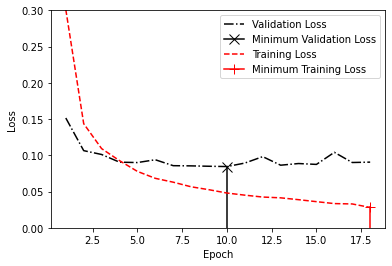

In [10]:
# These definitions make the plot code easier to read
minvalx=np.argmin(history.history['val_loss'])+1
minvaly=min(history.history['val_loss'])
mintrainx=np.argmin(history.history['loss'])+1
mintrainy=min(history.history['loss'])
lowpoint_val=np.array([[minvalx,-10],[minvalx,minvaly]])
lowpoint_train=np.array([[mintrainx,-10],[mintrainx,mintrainy]])

# N.B., it's always good to label axes and lines
plt.plot(list(range(1,len(history.history['val_loss'])+1)),history.history['val_loss'],'k-.',label='Validation Loss')
plt.plot(lowpoint_val[:,0],lowpoint_val[:,1],'kx-',markersize=10,label='Minimum Validation Loss')
plt.plot(list(range(1,len(history.history['loss'])+1)),history.history['loss'],'r--',label='Training Loss')
plt.plot(lowpoint_train[:,0],lowpoint_train[:,1],'r+-',markersize=10,label='Minimum Training Loss')
# creates legend from "label" attribute
plt.legend()
# y limit
plt.ylim([0,0.3])
# axes labels
plt.ylabel('Loss')
plt.xlabel('Epoch')
# show the plot
# to save figure, you can use plt.savefig(<file name>)
plt.show()


## Accuracy is only a number. Let's look at examples

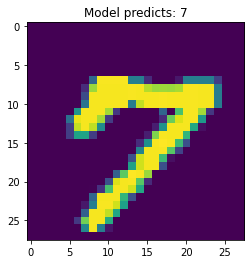

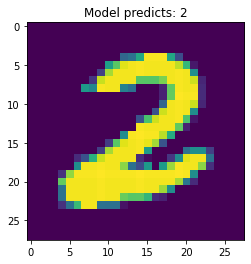

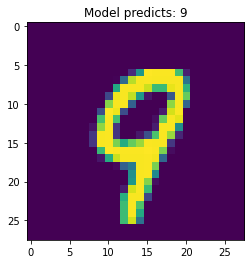

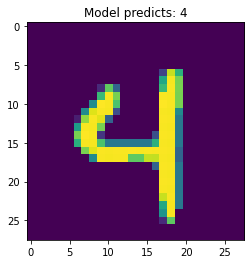

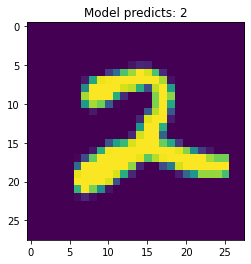

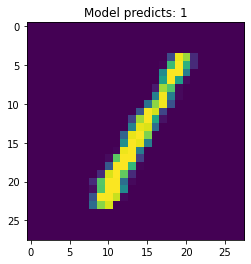

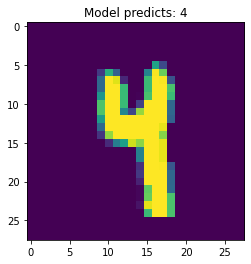

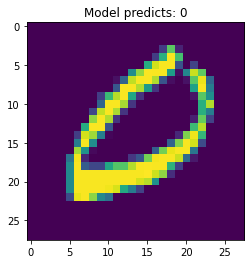

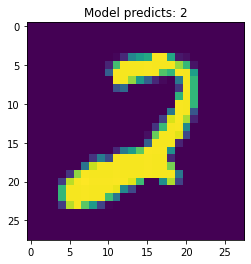

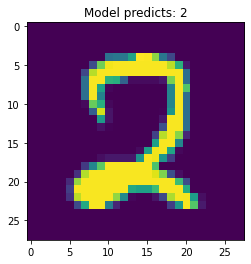

[2, 0, 4, 8, 7, 6, 0, 6, 3, 1, 8, 0, 7, 5, 9, 4, 3, 8, 4, 6, 6, 0, 2, 0, 3, 3, 6, 6, 4, 7, 9, 3, 7, 5, 4, 8, 2, 5, 5, 8, 5, 9, 2, 2, 2, 7, 0, 5, 1, 0, 7, 9, 9, 9, 6, 8, 5, 8, 6, 9, 9, 5, 4, 2, 8, 4, 1, 0, 6, 9, 5, 4, 1, 6, 6, 7, 5, 5, 2, 9, 0, 6, 4, 4, 2, 8, 7, 8, 3, 0, 9, 0, 1, 1, 9, 4, 5, 9, 1, 6, 6, 7, 7, 0, 8, 4, 8, 8, 1, 0, 8, 2, 9, 1, 0, 9, 7, 0, 4, 9, 6, 9, 3, 8, 3, 5, 3, 2, 4, 2, 4, 0, 3, 2, 3, 5, 1, 1, 2, 4, 8, 2, 2, 6, 8, 6, 1, 2, 6, 1, 0, 7, 3, 4, 7, 4, 6, 9, 8, 2, 6, 0, 8, 0, 9, 7, 8, 2, 9, 2, 3, 2, 8, 7, 0, 1, 0, 7, 8, 5, 1, 3, 1, 2, 9, 0, 7, 9, 8, 8, 3, 9, 3, 9, 7, 4, 9, 3, 1, 2, 2, 6, 0, 7, 6, 9, 5, 9, 7, 4, 2, 0, 1, 0, 9, 4, 9, 1, 9, 2, 2, 6, 5, 6, 0, 0, 2, 7, 7, 7, 4, 5, 1, 7, 7, 8, 2, 5, 9, 6, 6, 8, 0, 1, 2, 1, 7, 7, 7, 3, 0, 3, 4, 8, 3, 6, 3, 2, 0, 7, 5, 7, 2, 0, 5, 8, 8, 8, 7, 6, 1, 7, 1, 0, 1, 8, 6, 5, 1, 5, 3, 1, 9, 0, 8, 5, 7, 1, 0, 0, 6, 7, 4, 1, 1, 7, 4, 2, 4, 8, 9, 1, 0, 8, 3, 5, 8, 9, 9, 1, 8, 0, 1, 3, 9, 7, 1, 8, 4, 6, 5, 7, 6, 6, 2, 1, 2, 4, 7, 9, 7, 2, 5, 

In [14]:
for i in range(10):
    random_int=np.random.randint(0,len(ds_test_images))
    image=(np.array(list(ds_test_images)[random_int])/256)[:,:,0]
    plt.imshow(image)
    plt.title('Model predicts: '+str(predictions[random_int]))
    plt.show()

    

print(predictions)

#prediction != gt_label
#    append.list ()


#new_list 
#把 i 放在 new_list 



In [81]:
 
#a = np.asarray()
#a

In [82]:
#plt.figure()

# t-SNE

In [83]:
#time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(prediction)



[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...
[t-SNE] Computed neighbors for 10000 samples in 1.130s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.082571
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.187302
[t-SNE] KL divergence after 1000 iterations: 1.261159


In [84]:
# Utility function to visualize the outputs of PCA and t-SNE



10000
10000
10000


(<Figure size 576x576 with 1 Axes>,
 [Text(46.94558, 30.4566, '0'),
  Text(-46.573647, -44.658386, '1'),
  Text(5.8045425, -61.348824, '2'),
  Text(-36.17932, 39.701324, '3'),
  Text(18.523537, -19.435253, '4'),
  Text(-48.439587, 7.2477984, '5'),
  Text(59.492584, -9.368864, '6'),
  Text(4.124404, 60.900803, '7'),
  Text(3.342722, 18.880863, '8'),
  Text(-14.222149, -13.779049, '9')])

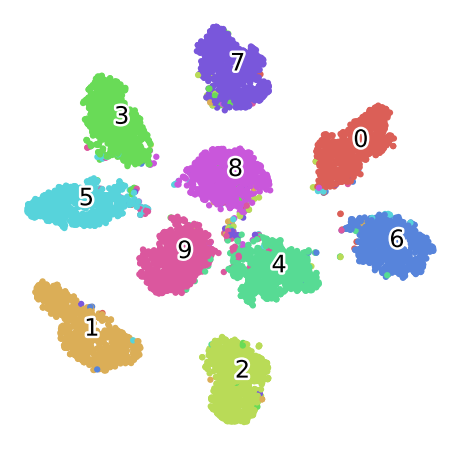

In [85]:
#Reference: https://www.datacamp.com/community/tutorials/introduction-t-sne
print(len(tsne_results))
print(len(prediction))
labels = np.asarray(gt_labels)
print(len(labels))

# Utility function to visualize the outputs of PCA and t-SNE

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

fashion_scatter(tsne_results, labels)

In [86]:
print(len(tsne_results))
print(len(prediction))
labels = np.asarray(gt_labels)
print(len(labels))
a = np.asarray(history)
print(a)

10000
10000
10000


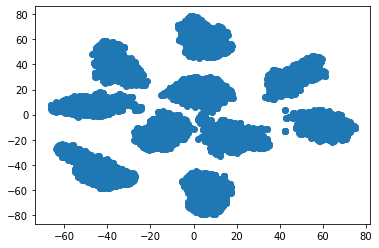

In [87]:


df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
#df_tsne['label'] = y[rows[:n_select]]sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)


plt.scatter(x = df_tsne['comp1'], y = df_tsne['comp2'])
#plt.scatter(x = df_tsne['comp1'], y = df_tsne['comp2'])

plt.show()



(<Figure size 576x576 with 1 Axes>,
 [Text(46.99623, 30.60214, '0'),
  Text(-46.634617, -44.69622, '1'),
  Text(5.8134995, -61.438408, '2'),
  Text(-36.348274, 39.727226, '3'),
  Text(18.570007, -19.582346, '4'),
  Text(-49.257217, 7.2097387, '5'),
  Text(59.60666, -9.4278, '6'),
  Text(4.098736, 61.069286, '7'),
  Text(3.366042, 18.98444, '8'),
  Text(-14.332951, -14.0265255, '9'),
  Text(nan, nan, '10')])

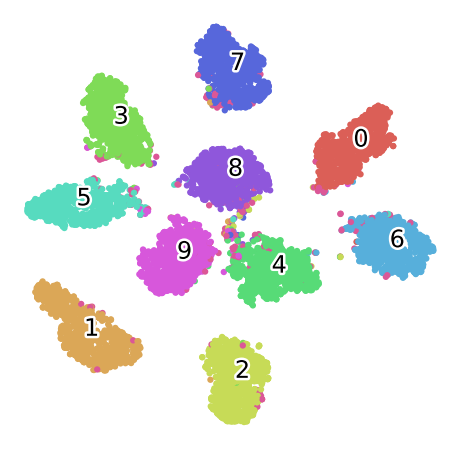

In [89]:
new_list = []
for i in range(len(predictions)):
    if predictions[i] != labels[i]:
        new_list.append(-1)
    else:
        new_list.append(predictions[i])
new_list = np.asarray(new_list)

fashion_scatter(tsne_results, new_list)